Проект **Разработка модели персонализированных предложений постоянным клиентам**

В рамках проекта главной задачей является построение модели, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца. С использованием данных модели и данных о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

Для выполнения данного проекта требуется осуществить следующие шаги по работе с данными компании:
1. Загрузка 4-х датафреймов данных, предварительный анализ соответствия содержания датафрейма его наименованию. 
2. Предобработка данных: обработка данных от дубликатов, пропусков.
3. Исследовательский анализ данных: поиск аномальных значений, расчет статистик данных.
4. Объединение датафреймов в один для дальнейшего моделирования
5. Корреляционный анализ зависимостей между признаками, устранение мультиколлинеарности при ее обнаружении.
6. Поиск лучшей модели из 4-х предсказания целевого признака
7. Интерпретация коэффтцтентов модели
8. Анализ выделенного сегмента покупателей с высокой долей покупок товаров по акции.

## Загрузка данных

In [1]:
pip install phik 

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install -U scikit-learn

In [3]:
!pip install shap
!pip install -U jinja2 -q

In [4]:
#импортируем необходимые для анализа библиотеки
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import sklearn
from sklearn.metrics import (
    mean_squared_error, 
    accuracy_score,
    precision_score, 
    recall_score,
    r2_score,
    confusion_matrix,
    mean_absolute_error
)
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import shap
from sklearn.feature_selection import SelectKBest, f_classif

In [5]:
#Запишем данные датафреймов
market_file = pd.read_csv('/datasets/market_file.csv', sep = ',', decimal = '.')
market_money = pd.read_csv('/datasets/market_money.csv', sep = ',', decimal = '.')
market_time = pd.read_csv('/datasets/market_time.csv', sep = ',')
money = pd.read_csv('/datasets/money.csv', sep = ';', decimal = ',')

In [6]:
# Проверим названий столбцов содержанию датафреймов. 
#Выведем датафрейм с данными, которые содержат данные о поведении покупателя на сайте 
display(market_file.head())
market_file.info()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [7]:
#Выведем датафрейм с данными о времени, проведенном на сайте покупателем 
display(market_time.head())
market_time.info()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [8]:
display(market_money.head())
market_money.info()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [9]:
#Выведем датафрейм с данными о выручке, которую магазин получает с покупателя  
display(money.head())
money.info()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


### Шаг загрузки данных выполнен
На данном этапе выгружены 4 датафрейма, характеризующие финансовую составляющую деятельности магазина за 3 мес. (выручка и прибыль поклиентно, выручка указана помесячно), а также покупательское поведение клиентов магазина, относящихся к различным категориям (премиум/стандарт). 
В датафреймах также допущены опечатки. Все эти неточности, анализ дубликатов и пропусков будут скорректированы и изучены на этапе предобработки данных. 

## Предобработка данных

На данном этапе необходимо привести в соответствие типы данных их содержанию, проверить на дубликаты, привести в соответствие текст в данных столбцов, исправив опечатки.  

In [10]:
# в датафрейме market_file приведем в соответствие форматы данных столбцов с маркетинговой активностью и акционными покупками
market_file['Маркет_актив_6_мес'] = market_file['Маркет_актив_6_мес'].astype('float')
market_file['Акционные_покупки'] = market_file['Акционные_покупки'].astype('float')
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [11]:
#проверка наличия пропусков в данных
pd.DataFrame(round(market_file.isna().mean()*100,)).style.background_gradient('coolwarm') 

,0
id,0.000000
Покупательская активность,0.000000
Тип сервиса,0.000000
Разрешить сообщать,0.000000
Маркет_актив_6_мес,0.000000
Маркет_актив_тек_мес,0.000000
Длительность,0.000000
Акционные_покупки,0.000000
Популярная_категория,0.000000
Средний_просмотр_категорий_за_визит,0.000000


In [12]:
#проверка на наличие дубликатов
market_file[market_file.duplicated()].count()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

In [13]:
#неявные дубликаты могут находиться в столбцах с текстовым описанием данных, проверим уникальные значения таких столбцов 
print (market_file['Покупательская активность'].unique(), market_file['Тип сервиса'].unique(), market_file['Популярная_категория'].unique())

['Снизилась' 'Прежний уровень'] ['премиум' 'стандартт' 'стандарт'] ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


In [14]:
market_file['Тип сервиса'] = (
    market_file['Тип сервиса'].
    str.replace('тт', 'т')
)
market_file['Тип сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [15]:
#Датафрейм market_time не требует изменения формата данных, поэтому проаналазируем пропуски в данных
pd.DataFrame(round(market_time.isna().mean()*100,)).style.background_gradient('coolwarm') 

,0
id,0.000000
Период,0.000000
минут,0.000000


In [16]:
#проверка на наличие дубликатов
market_time[market_time.duplicated()]

,id,Период,минут


In [17]:
#неявные дубликаты могут находиться в столбцах с текстовым описанием данных, проверим уникальные значения таких столбцов 
print (market_time['Период'].unique())

['текущий_месяц' 'предыдцщий_месяц']


In [18]:
#исправим опечатку 
market_time['Период'] = (
    market_time['Период'].
    str.replace('предыдцщий_месяц', 'предыдущий_месяц')
)
market_time['Период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

In [19]:
pd.DataFrame(round(market_money.isna().mean()*100,)).style.background_gradient('coolwarm') 

,0
id,0.000000
Период,0.000000
Выручка,0.000000


In [20]:
#проверка на наличие дубликатов
market_money[market_money.duplicated()]

,id,Период,Выручка


In [21]:
#Преобразуем данные в столбце выручка в формату float
market_money['Выручка'] = market_money['Выручка'].astype('float')
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [22]:
pd.DataFrame(round(money.isna().mean()*100,)).style.background_gradient('coolwarm') 

,0
id,0.000000
Прибыль,0.000000


In [23]:
#проверка на наличие дубликатов
money[money.duplicated()]

,id,Прибыль


### Шаг предобработки данных выполнен. 
Качество данных высокое, отсутствуют пропуски и дубликаты, были преобразованы соответствующие строки, выявленные на шаге загрузки данных, в необходимый для дальнейшего анализа формат, устранены неявные дубликаты. 
Таким образом, в рамках исследования будет осуществлен анализ 1300 покупателей

## Исследовательский анализ данных

Проведем исследовательский анализ данных с отбором покупателей, по которым была покупательская активность на протяжении последних трех месяцев в части покупок в анализируемом периоде. Для выполнения данного анализа необходимо объединить таблицы покупательсткой активности и таблицы с выручкой за последние 3 месяца по id покупателя. 
При этом данные представлены за разные промежутки времени (датафрейм с покупательской активностью за последние 6 мес., а датафрейм с выручкой за послежние 3 мес.). 
Поскольку анализируемый период - последние 3 мес., то пустые значения объединенного датафрейма необходимо будет удалить. 

In [24]:
market_money2 = pd.pivot_table(market_money, index=['id', 'Период'], values='Выручка').reset_index()
market_time2 = pd.pivot_table(market_time, index=['id', 'Период'], values='минут').reset_index()
market_total= pd.merge(market_money2, market_time2, on =['id', 'Период'], how ='inner')
market_total = pd.merge(market_total, market_file, on =['id'], how ='inner')
market_total=market_total[market_total['Выручка']>0]
market_total=market_total.dropna().drop_duplicates()
display(market_total.info())
pd.DataFrame(round(market_total.isna().mean()*100,)).style.background_gradient('coolwarm')

<class 'pandas.core.frame.DataFrame'>
Index: 2597 entries, 1 to 2599
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   2597 non-null   int64  
 1   Период                               2597 non-null   object 
 2   Выручка                              2597 non-null   float64
 3   минут                                2597 non-null   float64
 4   Покупательская активность            2597 non-null   object 
 5   Тип сервиса                          2597 non-null   object 
 6   Разрешить сообщать                   2597 non-null   object 
 7   Маркет_актив_6_мес                   2597 non-null   float64
 8   Маркет_актив_тек_мес                 2597 non-null   int64  
 9   Длительность                         2597 non-null   int64  
 10  Акционные_покупки                    2597 non-null   float64
 11  Популярная_категория               

None

,0
id,0.000000
Период,0.000000
Выручка,0.000000
минут,0.000000
Покупательская активность,0.000000
Тип сервиса,0.000000
Разрешить сообщать,0.000000
Маркет_актив_6_мес,0.000000
Маркет_актив_тек_мес,0.000000
Длительность,0.000000


In [28]:
market_money2 = market_money[market_money['Выручка']>0]
market_money2 = market_money2.pivot_table(index='id', columns='Период', values='Выручка', aggfunc='sum').reset_index().\
rename(columns={'предыдущий_месяц': 'Выручка_предыдущий_месяц', 'препредыдущий_месяц': 'Выручка_препредыдущий_месяц', 'текущий_месяц': 'Выручка_текущий_месяц'})
market_time2 = pd.pivot_table(market_time, index='id', columns='Период', values='минут', aggfunc='sum').reset_index().\
rename(columns={'предыдущий_месяц': 'Минуты_предыдущий_месяц', 'текущий_месяц': 'Минуты_текущий_месяц'})
market_total= pd.merge(market_money2, market_time2, on ='id', how ='inner')
market_total = pd.merge(market_total, market_file, on =['id'], how ='inner')
market_total=market_total.dropna().drop_duplicates()
market_total.info()
pd.DataFrame(round(market_total.isna().mean()*100,)).style.background_gradient('coolwarm')

<class 'pandas.core.frame.DataFrame'>
Index: 1297 entries, 1 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   Выручка_предыдущий_месяц             1297 non-null   float64
 2   Выручка_препредыдущий_месяц          1297 non-null   float64
 3   Выручка_текущий_месяц                1297 non-null   float64
 4   Минуты_предыдущий_месяц              1297 non-null   int64  
 5   Минуты_текущий_месяц                 1297 non-null   int64  
 6   Покупательская активность            1297 non-null   object 
 7   Тип сервиса                          1297 non-null   object 
 8   Разрешить сообщать                   1297 non-null   object 
 9   Маркет_актив_6_мес                   1297 non-null   float64
 10  Маркет_актив_тек_мес                 1297 non-null   int64  
 11  Длительность                       

,0
id,0.000000
Выручка_предыдущий_месяц,0.000000
Выручка_препредыдущий_месяц,0.000000
Выручка_текущий_месяц,0.000000
Минуты_предыдущий_месяц,0.000000
Минуты_текущий_месяц,0.000000
Покупательская активность,0.000000
Тип сервиса,0.000000
Разрешить сообщать,0.000000
Маркет_актив_6_мес,0.000000


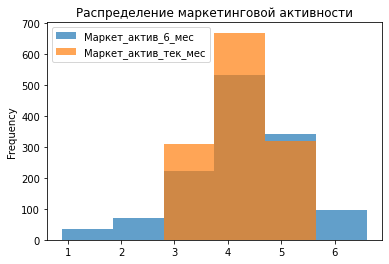

In [30]:
market_total[['Маркет_актив_6_мес', 'Маркет_актив_тек_мес']].plot.hist(bins=6,  alpha =0.7)
plt.legend()
plt.title('Распределение маркетинговой активности')
plt.show();

В последние 3 месяца среднее значение маркетиноговых коммуникаций составляло от 4-5 коммуникаций на клиенита. Значение также выдерживается в последнем месяце. Компания проводит от 3 до 5 маркетиновых коммуникаций на клиента.

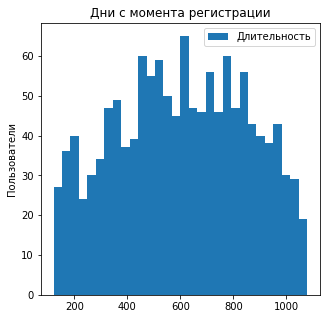

In [31]:
# Рассмотрим распределение данных по прошедшим дням с момента регистрации пользователя на сайте. 
market_total.plot(kind='hist', y='Длительность',  x='id',  bins = 30, title='Дни с момента регистрации', \
           ylabel="Пользователи", figsize=(5,5))
plt.show();

Гистограмма по количеству дней регистрации пользователей показывает, что пользователи с момента регистрации пользуются сайтом от полугода до 3х лет. При это количество пользователей с периодом времени, прошедшего с момента регистрации, которые в последний месяц совершали покупки, зарегистрировали 2 года назад. 

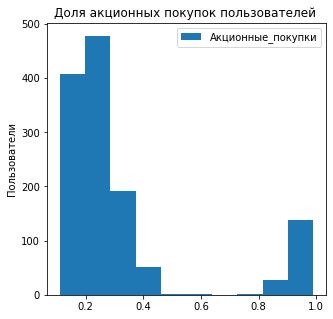

In [32]:
# Рассмотрим распределение данных по доли акционных покупок пользователей 
market_total.plot(kind='hist', y='Акционные_покупки',  x='id',  bins = 10, title='Доля акционных покупок пользователей ', \
           ylabel="Пользователи", figsize=(5,5))
plt.show();

Пользователи совершают покупки с использованием акций, преимущественно доля покупок по акции в общей доле покупок варьируется от 15% до 30%), но также необходимо отметить наличие категории пользователей, покупки которых преимущественно осуществляются только при наличии акции (доля акционных товаров в покупке у этих пользователей от 80% до 100%). 

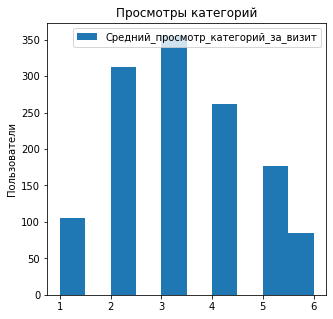

In [33]:
# Рассмотрим распределение данных по количеству просматриваемых категорий за визит
market_total.plot(kind='hist', y='Средний_просмотр_категорий_за_визит',  x='id',  bins = 10, title='Просмотры категорий', \
           ylabel="Пользователи", figsize=(5,5))
plt.show();

Магазин торгует следующими 6-ю товарными группами: 
Товары для детей, Домашний текстиль, Косметика и аксесуары, Техника для красоты и здоровья, Кухонная посуда, Мелкая бытовая техника и электроника. 

Наиболее часто пользователи просматривают 3-4 категории товаров. Наименьшую группу активных пользователей представляют пользователи, которые просмотривают либо 1, либо 6 категорий товаров. 

In [34]:
market_total.head()

,id,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Минуты_предыдущий_месяц,Минуты_текущий_месяц,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
1,215349,5216.0,4472.0,4971.6,12,10,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,5457.5,4826.0,5058.4,8,13,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,6158.0,4793.0,6610.4,11,13,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,5807.5,4594.0,5872.5,8,11,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,4738.5,5124.0,5388.5,10,10,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4


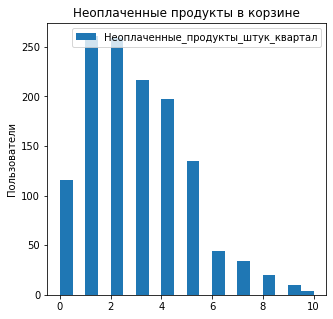

In [35]:
# Рассмотрим распределение данных по неоплаченным продуктам в корзине
market_total.plot(kind='hist', y='Неоплаченные_продукты_штук_квартал',  x='id',  bins = 20, title='Неоплаченные продукты в корзине', \
           ylabel="Пользователи", figsize=(5,5))
plt.show();

Потребительское поведение наибольшей доли покупателей предусматривает формирование отложенных товаров в корзине. Среднее количество откладываемых товаров в корзине составляетот 2 до 4х. 

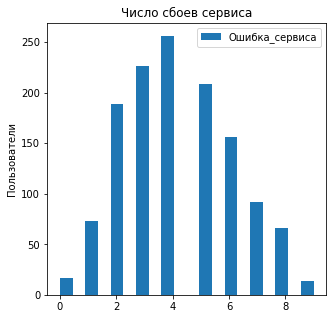

In [36]:
# Рассмотрим распределение данных по количеству сбоев, с которыми столкнулся покупатель во время посещения сайта
market_total.plot(kind='hist', y='Ошибка_сервиса',  x='id',  bins = 20, title='Число сбоев сервиса', \
           ylabel="Пользователи", figsize=(5,5))
plt.show();

Минимальное количество покупателей не столкнулись со сбоями в работе сервиса, наиболее частое количество сбоев сервиса в период покупки - от 2 до 4. КОличество покупателей, которых затронули сбои, довольно существенное. 

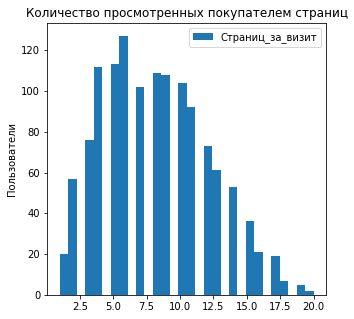

In [37]:
# Рассмотрим распределение данных по среднему количеству страниц, которые просмотрел покупатель во время посещения сайта
market_total.plot(kind='hist', y='Страниц_за_визит',  x='id',  bins = 30, title='Количество просмотренных покупателем страниц', \
           ylabel="Пользователи", figsize=(5,5))
plt.show();

Потребительское поведение клиентов магазина не предусматривает быстрые покупки, перед приобретением товара просматриваются 5-10 страниц товаров. 

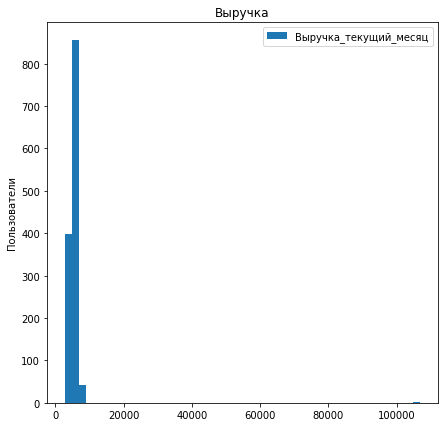

In [38]:
# Рассмотрим распределение данных по среднему количеству страниц, которые просмотрел покупатель во время посещения сайта
market_total.plot(kind='hist', y='Выручка_текущий_месяц',  x='id',  bins = 50, title='Выручка', \
           ylabel="Пользователи", figsize=(7,7))
plt.show();

In [39]:
#В данных наблюдается выброс выручки в размере, превышающем 100 тыс рублей на покупателя. Проаналазируем выброс
market_total[market_total['Выручка_текущий_месяц']>100000]

,id,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Минуты_предыдущий_месяц,Минуты_текущий_месяц,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
32,215380,6077.0,5051.0,106862.2,12,14,Снизилась,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7


Интернет-магазин «В один клик» реализует товары 6 различных категорий, при этом покупатели равномерно распределены по выручке, гистограмма выручки не имеет вершин, т.е. выручка с покупателя исчисляется в интервале от 500 до 4 000 рублей. 

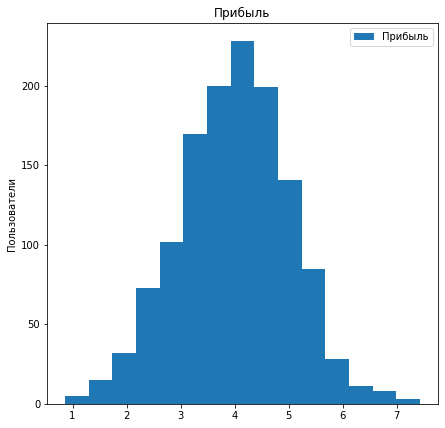

In [40]:
money.plot(kind='hist', y='Прибыль',  x='id',  bins = 15, title='Прибыль', \
           ylabel="Пользователи", figsize=(7,7))
plt.show();

Убыток у клиентов отсутствует, наиболее частый показатель прибыли составляет 4 руб. 

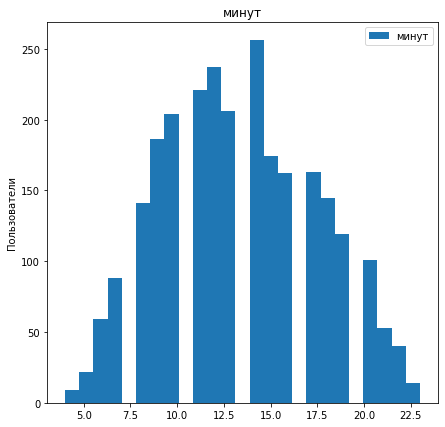

In [41]:
market_time.plot(kind='hist', y='минут',  x='id',  bins = 25, title='минут', \
           ylabel="Пользователи", figsize=(7,7))
plt.show();

Пользователи проводят на сайте от 12,5 до 15 минут в среднем. 

Перейдем к анализу категориальных признаков, для которых рассмотрим круговые диаграммы. 

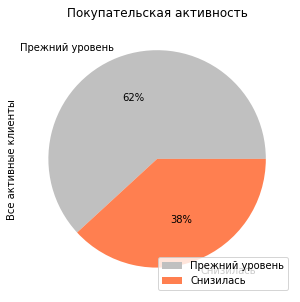

In [42]:
#Покупательская активнсть клиентов 
market_total.groupby(['Покупательская активность']).count().plot(kind='pie', y='id', autopct='%1.0f%%', colors = ['silver', 'coral'],\
                                                  title='Покупательская активность', ylabel="Все активные клиенты",\
                                                  figsize=(5,5))
plt.show();

Наблюдается высокая доля снижения покупательской активности клиентов, 38% клиентов имеют снижение активности. 

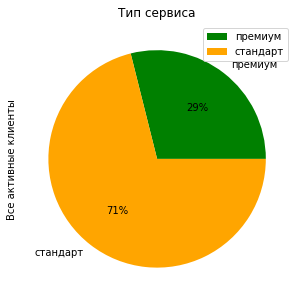

In [43]:
#Тип сервиса клиентов
market_total.groupby(['Тип сервиса']).count().plot(kind='pie', y='id', autopct='%1.0f%%', colors = ['green', 'orange'],\
                                                  title='Тип сервиса', ylabel="Все активные клиенты",\
                                                  figsize=(5,5))
plt.show();

Наибольшая группа клиентов магазина имеют принадлежность к стандартному уровню сервиса, уровень премиум - клиентов составляет только треть. 

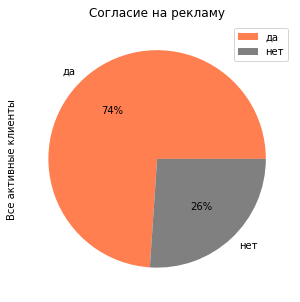

In [44]:
#Согласие клиентов на рекламу 
market_total.groupby(['Разрешить сообщать']).count().plot(kind='pie', y='id', autopct='%1.0f%%', colors = ['coral', 'gray'],\
                                                  title='Согласие на рекламу', ylabel="Все активные клиенты",\
                                                  figsize=(5,5))
plt.show();

Большая часть клиентов магазина не возражает против получения рассылок, что говорит о вовлеченности 74% аудитории в информацию о магазине. 

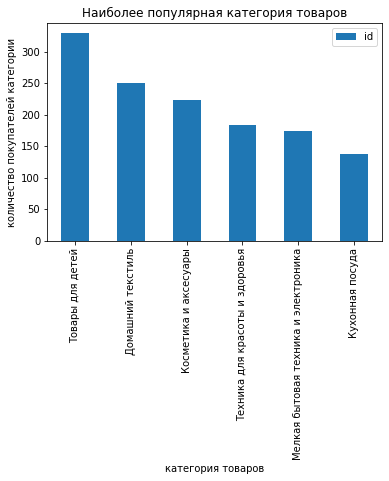

In [45]:
#Для описания данных о популярных категориях торгуемых товаров воспользуемся столбчатой диаграммой. 
pd.pivot_table(market_total, index=['Популярная_категория'], values=['id'], aggfunc='count').\
sort_values(by=[('id')], ascending=False).\
plot(title='Наиболее популярная категория товаров', kind='bar', xlabel= "категория товаров", ylabel="количество покупателей категории")
plt.show();

Наибольшей популярностью пользуются товары для детей, самая непопулярная категория товаров - кухонная посуда.  

### Шаг исследовательского анализа данных выполнен. 
В рамках данного шага была проанализирована покупательская активность пользователей магазина за последние 3 месяца. Данные в магазине на данном шаге позволили прийти к следующим основным выводам: 
1. Пользователи магазина зарегистрированы дано, являются постоянными покупателями магазина на протяжении более полугода. Наибольщее количество пользователей пользуются услугами магазина 2 года.
2. Пользователи магазина ориентируются на акции, доля совершенных покупок с акционными товарами от 20-40 %, также есть группа пользователей, которые приобретают товары только по акциям. 
3. Покупательское поведение пользователей не предусматривает импульсивные покупки, до приобретения товаров пользователь просматривает от 5 до 10 предложений товаров. 
4. Пользователи часто откладывают покупки в корзину
5. Наблюдается высокое количество сбоев в работе сайта, которое затрагивает пользователя, что может также влиять на тенденцию оттока пользователей. 
6. Выручка с каждого пользователя у магазина относительно равномерна, товары реализуют в примерно одинаковой ценовой категории. 
7. У магазина наибольшее количество пользователей стандартного сегмента (2/3). 
8. Высокая доля пользователей, у которых снижается активность (порядка 40%), показатель требует особого внимания. 

## Объединение таблиц

Объединение таблиц market_file, market_money2, market_time2 было осуществлено выше, таблицу для моделирования используем без аномального знаяения по выручке, а также добавим данные по минутам в предпредыдущий мсяц на основании медианного значения.

In [46]:
#объединим датафреймы с покупательским поведением и выручкой 
market_model = market_total[market_total['Выручка_текущий_месяц']<100000]
# market_model['Минуты_препредыдущий_месяц'] = market_model['Минуты_предыдущий_месяц'].mean()
market_model

,id,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Минуты_предыдущий_месяц,Минуты_текущий_месяц,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
1,215349,5216.0,4472.0,4971.6,12,10,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,5457.5,4826.0,5058.4,8,13,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,6158.0,4793.0,6610.4,11,13,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,5807.5,4594.0,5872.5,8,11,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,4738.5,5124.0,5388.5,10,10,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,3664.0,4704.0,4741.7,14,7,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11
1296,216644,4729.0,5299.0,5353.0,12,11,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9
1297,216645,5160.0,5334.0,5139.2,12,18,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7
1298,216646,4923.0,4725.0,5224.6,18,7,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7


In [47]:
market_model.shape

(1296, 18)

In [48]:
market_total.shape

(1297, 18)

### Шаг по объединению таблиц выполнен
Объединили 3 датафрейма в один, также ввиду того, что данные о времени использования пользователем приложения содержали данные не в полном объеме, а только за 2 месяца, то учли .  
Также в итоговой таблице в отдельные столбцы выделены помесячно данные о выручке и времени использования пользователем приложения.  

## Корреляционный анализ 

В соответствии с целью исследования необходимо проанализировать влияния на признак "Покупательская активность" других признаков. 
Исследуем влияние на покупательскую активность признаков сначала совокупно на признак, а затем в разбивке по категориям снижение активности и сохранение активности. 

In [49]:
market_model_cor = market_model.drop({'id'}, axis=1)

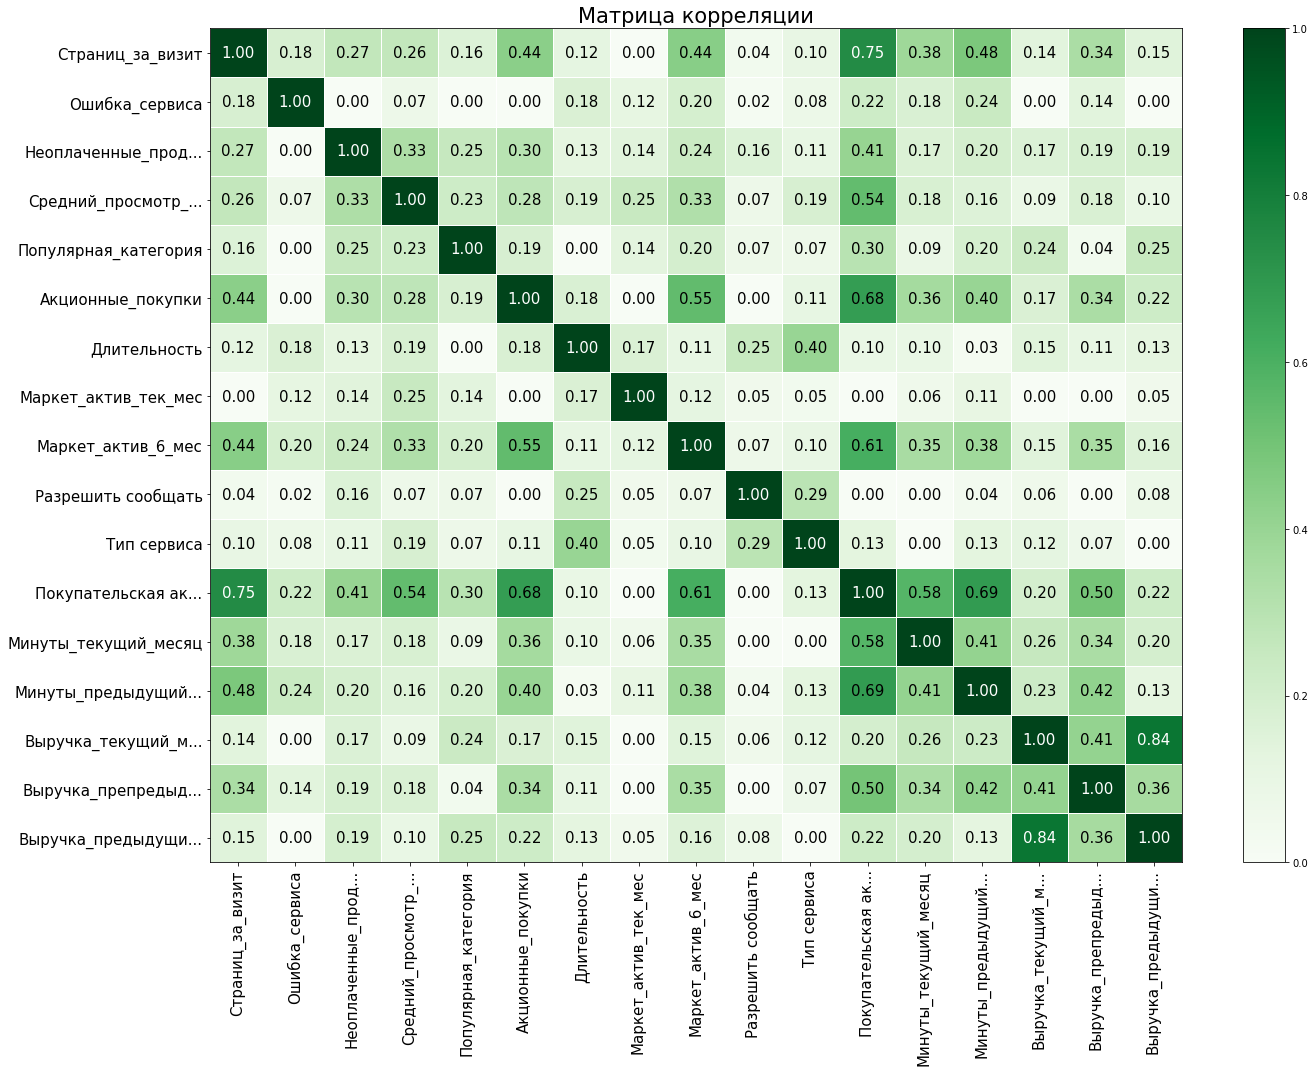

In [50]:
# создаём список с наименованиями непрерывных признаков
interval_cols = ['Выручка', 'минут', 'акционные покупки', 'Длительность', 'Средний_просмотр_категорий_за_визит', \
                 'Страниц_за_визит', 'Выручка', 'минут', 'Выручка_текущий_месяц', 'Выручка_предыдущий_месяц', \
                 'Выручка_препредыдущий_месяц', 'Минуты_текущий_месяц', 'Минуты_предыдущий_месяц', 'Минуты_препредыдущий_месяц']

phik_overview = phik_matrix(market_model_cor, interval_cols=interval_cols) 

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Матрица корреляции',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable Покупательская активность for analysis 1. Dropping this column
  warnings.warn(


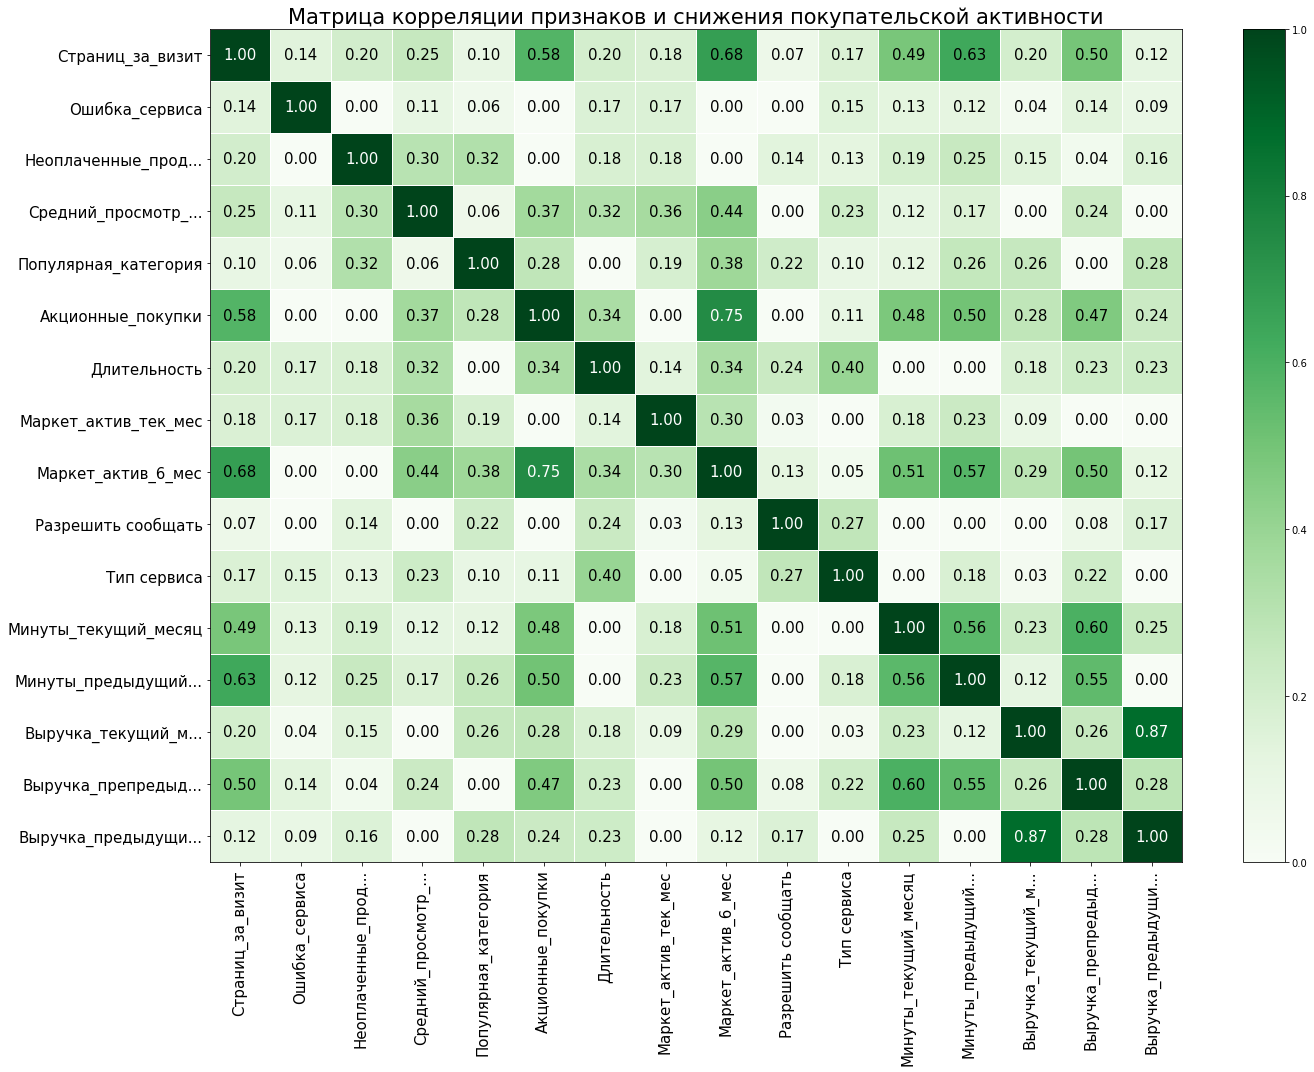

In [51]:
# построем матрицу влияния на целевой признак факторов в разрезе покупателей, по которым покупательская активность снизилась
phik_overview = phik_matrix(market_model_cor[market_model_cor['Покупательская активность']=='Снизилась'], interval_cols=interval_cols) 

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Матрица корреляции признаков и снижения покупательской активности',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable Покупательская активность for analysis 1. Dropping this column
  warnings.warn(


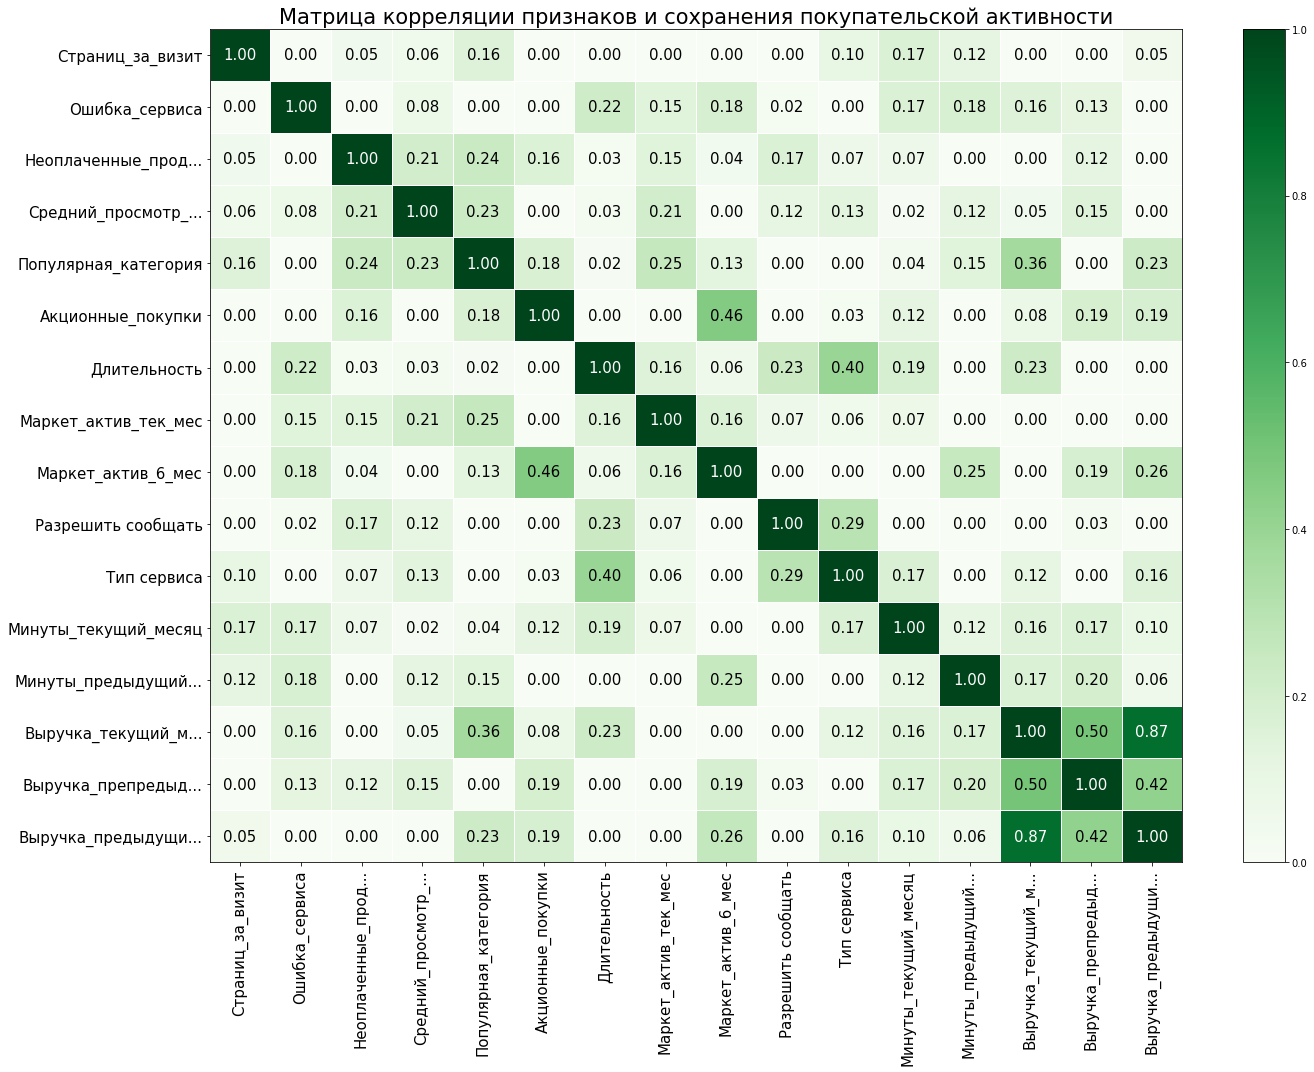

In [52]:
phik_overview = phik_matrix(market_model_cor[market_model_cor['Покупательская активность']=='Прежний уровень'], interval_cols=interval_cols) 

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Матрица корреляции признаков и сохранения покупательской активности',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Наблюдается мультиколлинеарность между общей выручкой и помесячной, а также между общим периодом и помесячным. Требуетя удаление данных признаков из датафрейма. 
Также наблюдаетяся мультиколлинераность между маркетиноговой активностью за последние 6 мес. и акционными покупками. Удалим из датафрейма показатель маркетиноговой активности за поледние 6 мес., поскольку связь данного показателя с целевым признаком слабее в 3-х случаях, чем связь акционных покупок и целевого признака. Оставим только маркетинговую активность текущего месяца. 


### Шаг корреляционный анализ выполнен
Согласно построенным матрицам корреляции была обнаружена мультиколлинеарность между общей выручкой и помесячной и общими минутами и помесячными. Также мультиколлинеарность наблюдается между маркетиноговой активностью и акционными покупками. Для построения модели мультиколлинеарные признаки были удалены. 
Относительно факторов, которые влияют на сохранение покупательской активности на прежнем уровне, необходимо отметить: 

Покупатели со снижением покупательской активности имеют различие с покупателями, по которым актиность сохранилась на прежнем уровне, по следующим показателям: маркетиноговая акивность, акционные покупки, время посещения сайта, количество просмотренных страниц за визит, проведенные минуты на сайте

## Использование пайплайнов

В рамках исследователького анализа данных было выяснено, что данные не сбалансированы (пользователи представлены разных сегментов, разное соотношение между пользователями с активностью на прежнем уровне и нет). 
В рамках работы с задачей необходимо решить задачу бинарной классификации - предсказать, что у пользователя снизится активность. Задача бинарной классификации и дисбаланс в классах — это работа для метрики ROC-AUC.


In [54]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    market_model.drop(['Покупательская активность','id'], axis=1), 
    market_model['Покупательская активность'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify =  market_model['Покупательская активность'])

X_train.shape, X_test.shape

# создаём списки с названиями признаков
ohe_columns = ['Разрешить сообщать', 'Популярная_катего
               рия']
ord_columns = ['Тип сервиса']
num_columns = ['Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', \
              'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Выручка_предыдущий_месяц',\
               'Выручка_препредыдущий_месяц', 'Минуты_текущий_месяц', 'Минуты_предыдущий_месяц',\
               'Маркет_актив_6_мес', 'Выручка_текущий_месяц']

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE

ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
         categories=[['премиум', 'стандарт']],
         handle_unknown='use_encoded_value', unknown_value=np.nan
     )
     ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель

pipe_final = Pipeline([
('preprocessor', data_preprocessor),
('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
# словарь для модели DecisionTreeClassifier()
    {
    'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
    'models__max_depth': range(2, 7),
    'models__max_features': range(2, 7),
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
# словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

# словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
# словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability= True)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)

randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Разрешить сообщать',
                                                   'Популярная_категория']),
                                                 ('ord',
                                 

In [55]:
y_test_pred = randomized_search.predict(X_test)
probabilities = randomized_search.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(y_test, probabilities_one))

Площадь ROC-кривой: 0.9175666383529507


### Шаг использование пайпланов выполнен
На основании анализа 4-х моделей предсказания наилучшей по признаку ROC-AUC является модель логичтисеской регрессии. 
Признак ROC-AUC был выбран ввиду несбалансированности данных в рамках необходимости решения задачи бинарной 
исследователького анализа данных было выяснено, что данные не сбалансированы (пользователи представлены разных сегментов, разное соотношение между пользователями с активностью на прежнем уровне и нет). В рамках работы с задачей необходимо решить задачу бинарной классификации - предсказать, что у пользователя снизится активность. Задача бинарной классификации и дисбаланс в классах — это работа для метрики ROC-AUC

## Анализ важности признаков

Построим визуализацию важности признаков лучшей модели логистической регрессии 

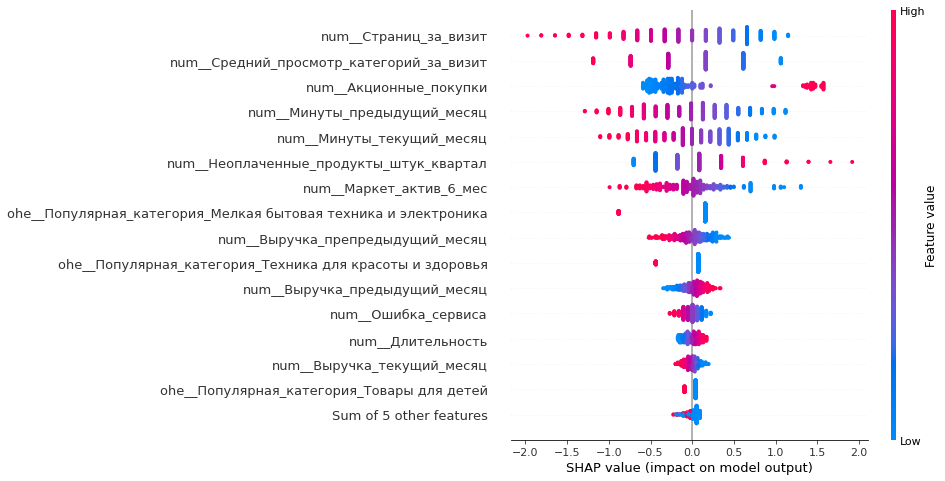

In [56]:
model = randomized_search.best_estimator_.named_steps['models']
preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']
X_train_2 = preprocessor.fit_transform(X_train) 
X_train_2 = preprocessor.fit_transform(X_train) 
X_test_2 = preprocessor.transform(X_test) 
feature_names = preprocessor.get_feature_names_out() 
X_test_2 = pd.DataFrame(X_test_2, columns=feature_names) 
explainer = shap.LinearExplainer(model, X_test_2)
shap_values = explainer(X_test_2)
shap.plots.beeswarm(shap_values, max_display=16) 

<Axes: ylabel='Feature'>

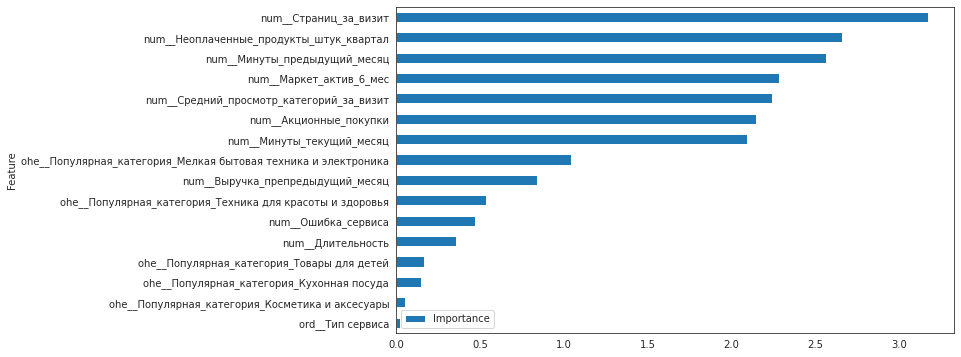

In [57]:
model.fit(X_train_2, y_train)
# инициализируем селектор и модель
selector = SelectKBest(f_classif, k=16)
# обучаем SelectKBest
selector.fit(X_train_2, y_train)

# обучаем SelectKBest
selector.fit(X_train_2, y_train)

feature_names = preprocessor.get_feature_names_out() 
X_train_2 = pd.DataFrame(X_train_2, columns=feature_names)
X_test_2 = preprocessor.transform(X_test) 
feature_names = preprocessor.get_feature_names_out() 
X_test_2 = pd.DataFrame(X_test_2, columns=feature_names) 

# формируем выборки с лучшими признаками
features_names = X_train_2.columns[selector.get_support(indices=True)]
X_train_new = X_train_2[list(features_names)]
X_test_new = X_test_2[list(features_names)]

# обучаем модель
model.fit(X_train_new, y_train)

# отложим значения коэффициентов на графике
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({'Feature': features_names, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values(by='Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

### Шаг Анализ важности признаков выполнен
На основании построенной визуализации можно заключить, что ключевой вклад в модель предсказания целевого признака вносят следующие параметры: 
Полученная выручка за предпрошедший месяц и минуты за предпрошедщий месяц, также особую важность играют минуты в текущем месяце и количество посещаемых пользователем страниц за визит, акционные покупки. 

##  Сегментация покупателей

Проанализируем группу клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.
Для анализа данной категории потребуется построение матриц корреляции с признаками. 


In [58]:
# найдем вероятности, с которыми модель классифицирует объект 
model.fit(X_train_2, y_train)
y_pred = model.predict(X_test_2)
y_proba = model.predict_proba(X_test_2)[:, 1]

In [59]:

#Преобразуем датафрейм с тестовыми данными, вернем в него id пользователей и рассчитанные предсказания модели, 
# а также добавим вероятности предсказаний и данные о прибыли
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    market_model.drop(['Покупательская активность'], axis=1), 
    market_model['Покупательская активность'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify =  market_model['Покупательская активность'])

X_test_1['Покупательская активность'] = y_pred 
X_test_1['Вероятность отнесения к классу снизилась'] = y_proba
classification = pd.merge(X_test_1, money, on ='id', how ='inner').drop_duplicates().reset_index()
classification.head() 

,index,id,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Минуты_предыдущий_месяц,Минуты_текущий_месяц,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,...,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Покупательская активность,Вероятность отнесения к классу снизилась,Прибыль
0,0,216161,3973.0,4912.0,3289.2,16,17,стандарт,да,4.1,...,606,0.15,Техника для красоты и здоровья,6,1,4,12,Прежний уровень,0.012452,4.69
1,1,215654,3548.0,4656.0,4170.7,11,9,премиум,нет,1.4,...,684,0.94,Товары для детей,3,6,1,6,Снизилась,0.987159,2.75
2,2,216307,5444.0,4565.0,6335.8,20,11,премиум,да,3.3,...,488,0.13,Домашний текстиль,4,2,8,10,Прежний уровень,0.110079,3.16
3,3,215501,6604.0,4993.0,6758.7,9,9,премиум,да,3.5,...,1057,0.35,Домашний текстиль,4,3,5,6,Снизилась,0.786147,3.74
4,4,215934,5090.0,4451.0,5773.8,15,18,стандарт,нет,5.5,...,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,Снизилась,0.513083,4.40


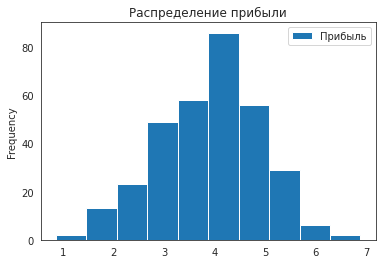

In [60]:
classification['Прибыль'].plot.hist(bins=10)
plt.legend()
plt.title('Распределение прибыли')
plt.show();

По построенной гистограмме распределения прибыли можно увидеть, что наибольшие вершины гистограграммы, начинаются с 3. Следовательно, с точки зрения анализа прибыльных клиентов, воспользуемся пороогом прибыли равным 3. 

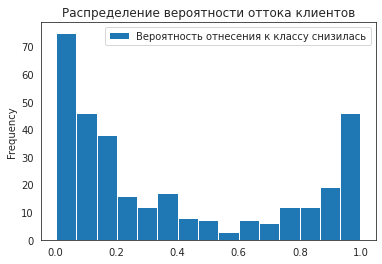

In [61]:
classification['Вероятность отнесения к классу снизилась'].plot.hist(bins=15)
plt.legend()
plt.title('Распределение вероятности оттока клиентов')
plt.show();

По построенной гистограмме распределения вероятности оттока можно увидеть, что, начиная с порога вероятности 0.7 начинается резкий отток клиентов. 

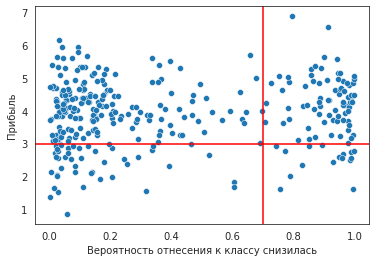

In [62]:
# Построим диаграмму рассеянения по признакам с порогами прибыли 3 и вероятности оттока клиента 0.7
sns.scatterplot(data = classification, x = 'Вероятность отнесения к классу снизилась', y = 'Прибыль')
plt.axvline(x = 0.7, color = 'red')
plt.axhline(y = 3, color = 'red')
plt.show()

По выделенному сегменту покупателей разделим данный класс клиентов на 2 категории: с высокой долей акционных покупок и остальные

In [63]:
classification_1 = classification[(classification['Вероятность отнесения к классу снизилась']>=0.7) & \
                                  (classification['Прибыль']>=3)] 
classification_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76 entries, 3 to 323
Data columns (total 21 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   index                                     76 non-null     int64  
 1   id                                        76 non-null     int64  
 2   Выручка_предыдущий_месяц                  76 non-null     float64
 3   Выручка_препредыдущий_месяц               76 non-null     float64
 4   Выручка_текущий_месяц                     76 non-null     float64
 5   Минуты_предыдущий_месяц                   76 non-null     int64  
 6   Минуты_текущий_месяц                      76 non-null     int64  
 7   Тип сервиса                               76 non-null     object 
 8   Разрешить сообщать                        76 non-null     object 
 9   Маркет_актив_6_мес                        76 non-null     float64
 10  Маркет_актив_тек_мес                      76

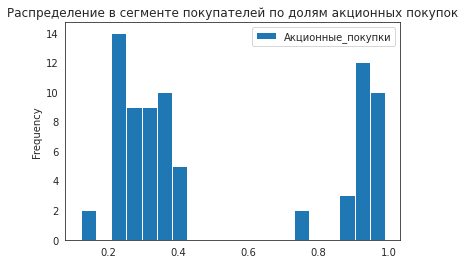

In [64]:
# проанализируем распределение данных по криерию акционных покупок
classification_1['Акционные_покупки'].plot.hist(bins=20)
plt.legend()
plt.title('Распределение в сегменте покупателей по долям акционных покупок')
plt.show();

Порогом в рамках выделенного сегмента выступает значение 0.6 

In [65]:
# разделим исследуемые сегменты по отношению к акционным товарам и построим матрицы корреляций 
classification_1['отношение к ационным товарам'] = classification_1.apply(lambda x: 'нейтральное' if x['Акционные_покупки']< 0.6 else 'положительное', axis=1)
classification_1['отношение к ационным товарам'].unique()

/tmp/ipykernel_393/289443257.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classification_1['отношение к ационным товарам'] = classification_1.apply(lambda x: 'нейтральное' if x['Акционные_покупки']< 0.6 else 'положительное', axis=1)


array(['нейтральное', 'положительное'], dtype=object)

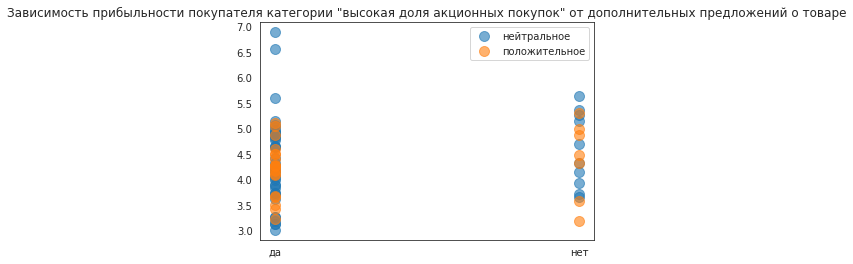

In [66]:
groups = classification_1.groupby('отношение к ационным товарам')
for name, group in groups:
    plt.plot (group['Разрешить сообщать'], group['Прибыль'], marker='o', linestyle='', markersize=10, label=name, alpha =0.6)
    plt.title('Зависимость прибыльности покупателя категории "высокая доля акционных покупок" от дополнительных предложений о товаре')
plt.legend()
plt.show();

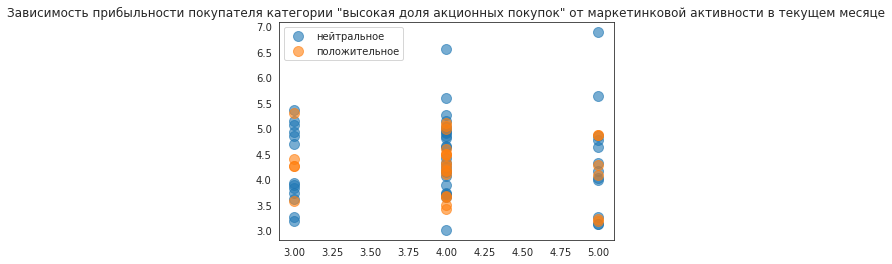

In [67]:
groups = classification_1.groupby('отношение к ационным товарам')
for name, group in groups:
    plt.plot (group['Маркет_актив_тек_мес'], group['Прибыль'], marker='o', linestyle='', markersize=10, label=name, alpha =0.6)
    plt.title('Зависимость прибыльности покупателя категории "высокая доля акционных покупок" от маркетинковой активности в текущем месяце')
plt.legend()
plt.show();

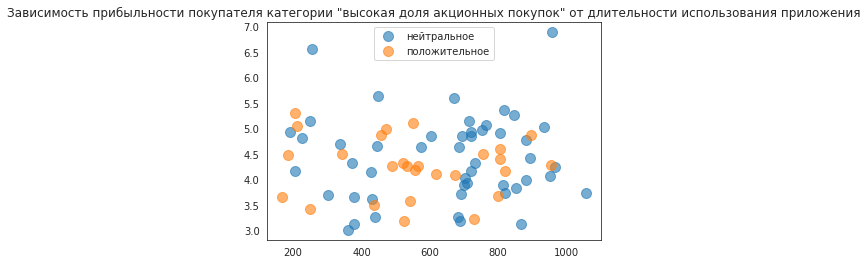

In [68]:
groups = classification_1.groupby('отношение к ационным товарам')
for name, group in groups:
    plt.plot (group['Длительность'], group['Прибыль'], marker='o', linestyle='', markersize=10, label=name, alpha =0.6)
    plt.title('Зависимость прибыльности покупателя категории "высокая доля акционных покупок" от длительности использования приложения')
plt.legend()
plt.show();

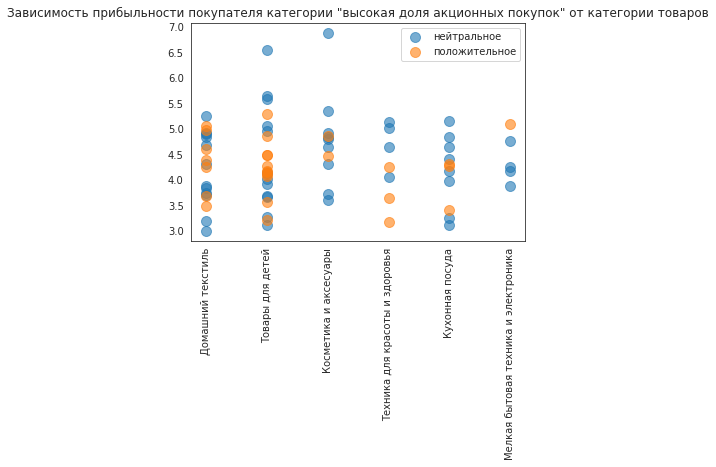

In [69]:
groups = classification_1.groupby('отношение к ационным товарам')
for name, group in groups:
    plt.plot (group['Популярная_категория'], group['Прибыль'], marker='o', linestyle='', markersize=10, label=name, alpha =0.6)
    plt.title('Зависимость прибыльности покупателя категории "высокая доля акционных покупок" от категории товаров')
plt.xticks(rotation=90)
plt.legend()
plt.show();

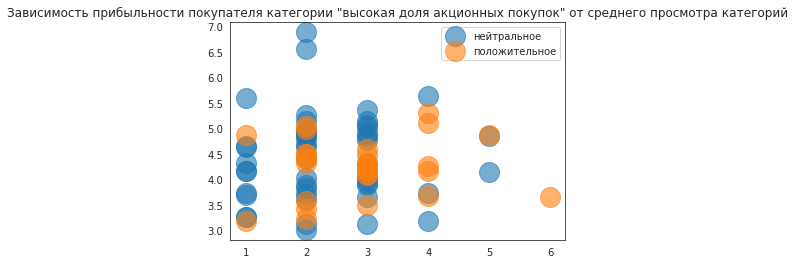

In [70]:
groups = classification_1.groupby('отношение к ационным товарам')
for name, group in groups:
    plt.plot (group['Средний_просмотр_категорий_за_визит'], group['Прибыль'], marker='o', linestyle='', markersize=20, label=name, alpha =0.6)
    plt.title('Зависимость прибыльности покупателя категории "высокая доля акционных покупок" от среднего просмотра категорий')
plt.legend()
plt.show();

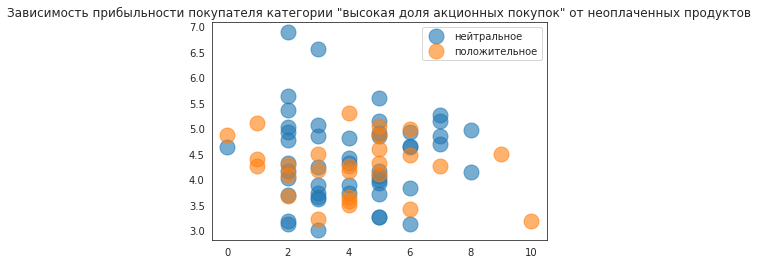

In [71]:
groups = classification_1.groupby('отношение к ационным товарам')
for name, group in groups:
    plt.plot (group['Неоплаченные_продукты_штук_квартал'], group['Прибыль'], marker='o', linestyle='', markersize=15, label=name, alpha =0.6)
    plt.title('Зависимость прибыльности покупателя категории "высокая доля акционных покупок" от неоплаченных продуктов')
plt.legend()
plt.show();

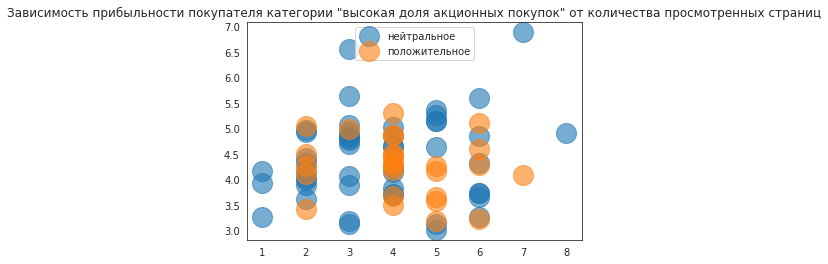

In [72]:
groups = classification_1.groupby('отношение к ационным товарам')
for name, group in groups:
    plt.plot (group['Страниц_за_визит'], group['Прибыль'], marker='o', linestyle='', markersize=20, label=name, alpha =0.6)
    plt.title('Зависимость прибыльности покупателя категории "высокая доля акционных покупок" от количества просмотренных страниц')
plt.legend()
plt.show();

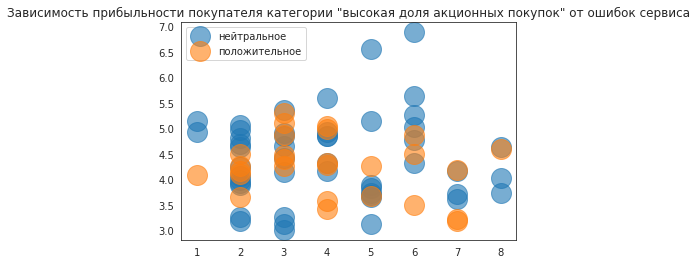

In [73]:
groups = classification_1.groupby('отношение к ационным товарам')
for name, group in groups:
    plt.plot (group['Ошибка_сервиса'], group['Прибыль'], marker='o', linestyle='', markersize=20, label=name, alpha =0.6)
    plt.title('Зависимость прибыльности покупателя категории "высокая доля акционных покупок" от ошибок сервиса')
plt.legend()
plt.show();

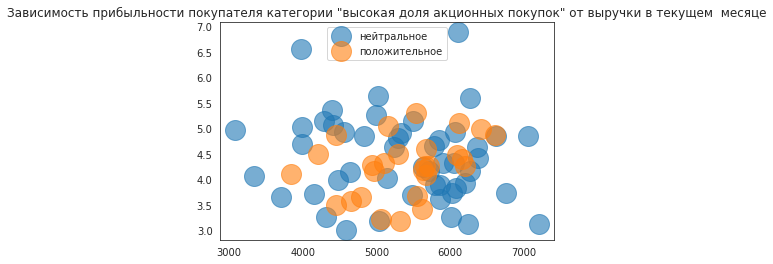

In [74]:
groups = classification_1.groupby('отношение к ационным товарам')
for name, group in groups:
    plt.plot (group['Выручка_текущий_месяц'], group['Прибыль'], marker='o', linestyle='', markersize=20, label=name, alpha =0.6)
    plt.title('Зависимость прибыльности покупателя категории "высокая доля акционных покупок" от выручки в текущем  месяце')
plt.legend()
plt.show();

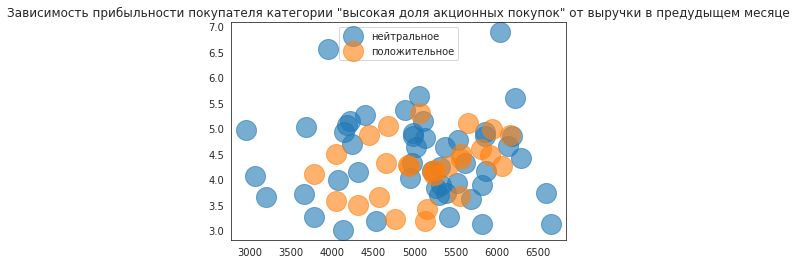

In [75]:
groups = classification_1.groupby('отношение к ационным товарам')
for name, group in groups:
    plt.plot (group['Выручка_предыдущий_месяц'], group['Прибыль'], marker='o', linestyle='', markersize=20, label=name, alpha =0.6)
    plt.title('Зависимость прибыльности покупателя категории "высокая доля акционных покупок" от выручки в предудыщем месяце')
plt.legend()
plt.show();

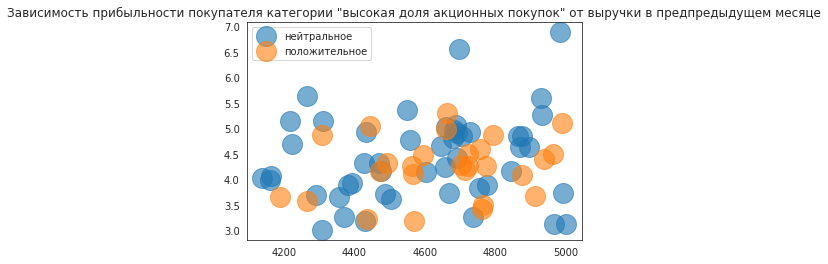

In [76]:
groups = classification_1.groupby('отношение к ационным товарам')
for name, group in groups:
    plt.plot (group['Выручка_препредыдущий_месяц'], group['Прибыль'], marker='o', linestyle='', markersize=20, label=name, alpha =0.6)
    plt.title('Зависимость прибыльности покупателя категории "высокая доля акционных покупок" от выручки в предпредыдущем месяце')
plt.legend()
plt.show();

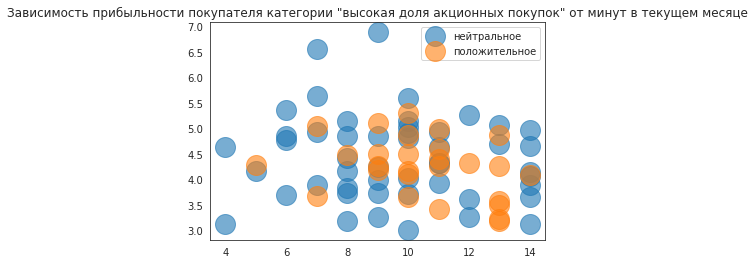

In [77]:
groups = classification_1.groupby('отношение к ационным товарам')
for name, group in groups:
    plt.plot (group['Минуты_текущий_месяц'], group['Прибыль'], marker='o', linestyle='', markersize=20, label=name, alpha =0.6)
    plt.title('Зависимость прибыльности покупателя категории "высокая доля акционных покупок" от минут в текущем месяце')
plt.legend()
plt.show();

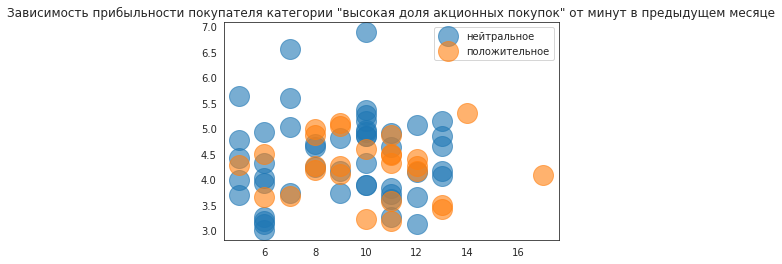

In [78]:
groups = classification_1.groupby('отношение к ационным товарам')
for name, group in groups:
    plt.plot (group['Минуты_предыдущий_месяц'], group['Прибыль'], marker='o', linestyle='', markersize=20, label=name, alpha =0.6)
    plt.title('Зависимость прибыльности покупателя категории "высокая доля акционных покупок" от минут в предыдущем месяце')
plt.legend()
plt.show();

### Шаг 8. Сегментация покупателей выполен
В рамках проанализируемого сегмента покупателей с высокой вероятностью снижения покупательсткой способности в следующих месяцах, которые склоны приобретать товары по акции, были построены корреляционные графики.
Была выделена категория клиентов с высокой вероятностью оттока в последующих месяцах, которые при этом приносят прибыль магазину с покупок. 
Исходя из анализа различий покупательского поведения клиентов, которые нейтрально относятся к акциям и тех, кто чувтсвительны к ним, необходимо отметить следующие рекомендации: 
1. На зарабатываемую прибыль влияют ошибки сервиса, рекомендуется наладить стабильность работы онлайн-магазина
2. Маркетинговая активность должна иметь различие для клиентов с нейтральным отношениям к акциям и чувтсвительным к акциям, поскольку большая прибыль по клиентам, которые нейтрально относятся к приобретению товаров по акций в зависимости от критерия маркетиноговой активности 
3. Клиенты, которые разрешили сообщать им об акциях имеют иакую же прибыль как и клиенты, которые не разрешили сообщать об акциях, что говорит о том, что маркетинговые рассылки работают неэффективно. 
4. Наиболее популярной категорией товаров являются товары для детей, исходя из этапа предобработки данных, при этом данная категория менее прибыльна, чем домашний текстиль, которая также пользуется популярностью клентов, любящих акции, возможно, целевая маркетинговая рассылка должна быть направлена на эту категорию товаров. 
5. Люди с положительным отношением к акциям долго не выбирают товары, просматривают 1-3 страницы перед покупкой, необходимо разработать механизм в приложении, который показывает аналоги товарных групп, чтобы пользователи дольше находились в приложении, просматривали больше страниц, поскольку чем дольше пользователь проводит времени в приложении, тем выше прибыль он приносит.


##  Общий вывод

В рамках проведенного исследования были проанализированы 4 датафрейма, характеризующие финансовую составляющую деятельности магазина за 3 мес. (выручка и прибыль поклиентно, выручка указана помесячно), а также покупательское поведение клиентов магазина, относящихся к различным категориям (премиум/стандарт). В датафреймах были допущены опечатки, при этом необходимо отметить высокое качество данных. Для исследования были предоставлены данные о 1300 покупателей
Пользователи магазина зарегистрированы дано, являются постоянными покупателями магазина на протяжении более полугода. Наибольщее количество пользователей пользуются услугами магазина 2 года. Пользователи магазина ориентируются на акции, доля совершенных покупок с акционными товарами от 20-40 %, также есть группа пользователей, которые приобретают товары только по акциям. Покупательское поведение пользователей не предусматривает импульсивные покупки, до приобретения товаров пользователь просматривает от 5 до 10 предложений товаров. Выручка с каждого пользователя у магазина относительно равномерна, товары реализуют в примерно одинаковой ценовой категории. У магазина наибольшее количество пользователей стандартного сегмента (2/3).
Высокая доля пользователей, у которых снижается активность (порядка 40%), показатель требует особого внимания.
В рамках исследовательского анализа данных по матрицам корреляции была обнаружена мультиколлинеарность между общей выручкой и помесячной и общими минутами и помесячными. Также мультиколлинеарность наблюдается между маркетиноговой активностью и акционными покупками. Для построения модели мультиколлинеарные признаки были удалены. Относительно факторов, которые влияют на сохранение покупательской активности на прежнем уровне, необходимо отметить:
Покупатели со снижением покупательской активности имеют различие с покупателями, по которым актиность сохранилась на прежнем уровне, по следующим показателям: маркетиноговая акивность, акционные покупки, время посещения сайта, количество просмотренных страниц за визит, проведенные минуты на сайте

Для выполнения главной цели ислледования были с испольщованием пайплайнов использованы 4-х модели предсказания снижеения покупательской активности покупателей в последующие 3 месяца, наилучшей по признаку ROC-AUC является модель логичтисеской регрессии. Признак ROC-AUC был выбран ввиду несбалансированности данных в рамках необходимости решения задачи бинарной исследователького анализа данных было выяснено, что данные не сбалансированы (пользователи представлены разных сегментов, разное соотношение между пользователями с активностью на прежнем уровне и нет). 

На основании построенной визуализации важности признаков модели логичтической регрессии можно заключить, что ключевой вклад в модель предсказания целевого признака вносят следующие параметры: Полученная выручка за предпрошедший месяц и минуты за предпрошедщий месяц, также особую важность играют минуты в текущем месяце и количество посещаемых пользователем страниц за визит, акционные покупки.

Также был лополнительно проанализирован сегмент покупателей с высокой вероятностью снижения покупательсткой способности в следующих месяцах, которые склоны приобретать товары по акции, были построены корреляционные графики, на основании которых необходимо отметить зависимость прибыли данного сегмента покупателей от выручки, полученной в текущем месяце, т.е. чем выше полученная выручка в текущем месяцев, тем выше вероятость, что в следующем месяце покупательская автивность снизится. Также наблюдается линейная зависимость данной категории потребителей от длительности использования приложения с момента регистрации, чем дольше потребители пользуются приложением, тем больше прибыли приносят.